In [ ]:
! pip install xgboost
! pip install optuna

In [ ]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data 불러오기
df = pd.read_csv('/content/drive/MyDrive/ZDRSJ/ML/data/ml_data.csv')

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace= True)
df.head(5)

,year,전용면적(㎡)_x,price,employment_rate(%),GDP(won),economysc,consumeprc,migrationpop,bankloan(1bw),room,...,enc_주교동,enc_주엽동,enc_중산동,enc_지축동,enc_탄현동,enc_토당동,enc_풍동,enc_행신동,enc_향동동,enc_화정동
0,2012,59,21356,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0
1,2012,84,25238,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0
2,2012,101,30607,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0
3,2012,124,37333,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0
4,2012,153,38075,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

# train-test분리
cut = int(len(df)*0.8) # traun, valid 80:20 으로 split
train_tmp = df[:cut]
test = df[cut:]
df = train_tmp

In [ ]:
# 교차 검증 
# 모델 선정 위해 (XGB, LGB) 모델의 성능 비교

'''
 시계열 데이터 - TimeSeriesSplit 기법을 사용
 10개의 폴드로 구분
  1) 과거의 데이터부터 끊어서 학습
  2) 다음 폴드부터 이전 폴드까지 이용하여 반복적으로 교차검증
  3) 미래의 데이터는 절대 학습하지 않으며 무조건 검증으로 사용됨
'''


def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5 
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10) # 10개의 폴드로 구분
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
# # 모델 성능 확인용 dataframe - 단지명, adr_dong 제거

# df_tmp = df.drop(df[['단지명','adr_dong']], axis=1)
# df_tmp.head()

In [ ]:
# XGB, LGB 모델 설정 

model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [ ]:

models = []
scores = []
for model in [model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

XGBRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[07:05:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  10%|█         | 1/10 [00:02<00:18,  2.03s/it]

[07:05:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:14<01:06,  8.26s/it]

[07:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:35<01:38, 14.09s/it]

[07:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:40<01:02, 10.41s/it]

[07:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:46<00:43,  8.77s/it]

[07:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  60%|██████    | 6/10 [00:53<00:32,  8.22s/it]

[07:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  70%|███████   | 7/10 [01:01<00:24,  8.27s/it]

[07:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  80%|████████  | 8/10 [01:11<00:17,  8.66s/it]

[07:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  90%|█████████ | 9/10 [01:22<00:09,  9.38s/it]

[07:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [01:34<00:00,  9.44s/it]


1 FOLDS: XGBRegressor RMSLE: 7146.1535
2 FOLDS: XGBRegressor RMSLE: 3783.9758
3 FOLDS: XGBRegressor RMSLE: 3729.7018
4 FOLDS: XGBRegressor RMSLE: 3844.2724
5 FOLDS: XGBRegressor RMSLE: 5345.7513
6 FOLDS: XGBRegressor RMSLE: 4065.4309
7 FOLDS: XGBRegressor RMSLE: 4800.1294
8 FOLDS: XGBRegressor RMSLE: 12842.9119
9 FOLDS: XGBRegressor RMSLE: 11442.9825
10 FOLDS: XGBRegressor RMSLE: 13235.4239

XGBRegressor mean RMSLE: 7023.6734


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

1 FOLDS: LGBMRegressor RMSLE: 7508.1104
2 FOLDS: LGBMRegressor RMSLE: 4220.6466
3 FOLDS: LGBMRegressor RMSLE: 3850.0369
4 FOLDS: LGBMRegressor RMSLE: 4141.6545
5 FOLDS: LGBMRegressor RMSLE: 6472.0819
6 FOLDS: LGBMRegressor RMSLE: 4262.0518
7 FOLDS: LGBMRegressor RMSLE: 4861.7147
8 FOLDS: LGBMRegressor RMSLE: 13713.1906
9 FOLDS: LGBMRegressor RMSLE: 11111.8794
10 FOLDS: LGBMRegressor RMSLE: 13615.7207

LGBMRegressor mean RMSLE: 7375.7087


In [ ]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,XGBRegressor,7023.673362
1,LGBMRegressor,7375.708732


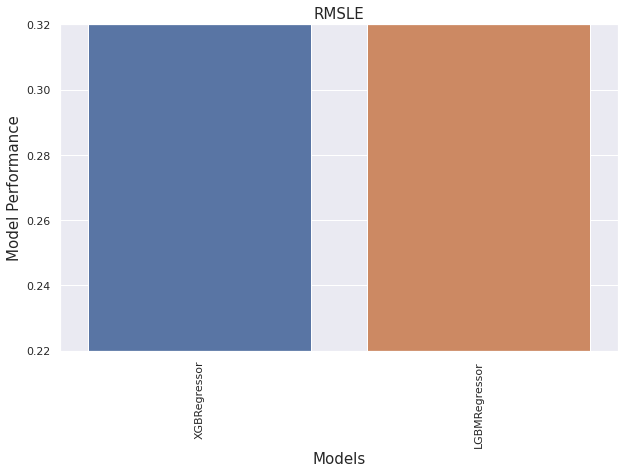

In [ ]:
# 모델 성능 시각화하여 확인

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 0.32)
plt.title('RMSLE', fontsize=15)
plt.show()

In [ ]:
# train, valid split 

cut = int(len(df)*0.8) # traun, valid 80:20 으로 split
train = df[:cut]
valid = df[cut:]

train_X = train.drop('price', axis=1)
train_y = train['price']
valid_X = valid.drop('price', axis=1)
valid_y = valid['price']
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)

(9048, 41) (9048,) (2263, 41) (2263,)


In [ ]:
train_X.head()

In [ ]:
# 하이퍼 파라미터 튜닝
# 시간 이슈 때문에 TimeSeriesSplit은 적용하지 않음

from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(train_X, label=train_y)
    dtest = lgb.Dataset(valid_X, label=valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(valid_y, lgb_model.predict(valid_X))
    return rmse
       
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

In [ ]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

In [ ]:
# test = test.drop(test['price'], axis=1)

In [ ]:
# 데이터에 LightGBM model 적용

final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test)

In [ ]:
final_lgb_pred

In [ ]:
plt.barh(train_X.columns, final_lgb_model.feature_importances_)